In [605]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [606]:

dates = pd.read_csv('data/dates.csv')
dates = pd.to_datetime(dates['date']).dt.date.values

nlsdf = pd.read_csv('data/NLSdf.csv')
nlsdf['datetime'] = pd.to_datetime(nlsdf['datetime'])
nlsdf


,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila
...,...,...,...,...,...,...,...,...,...
28102,2023-05-07 15:50:00,-0.050000,-0.525000,0.550000,0.5,0.272500,0.240000,0.120000,joensuu
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila
28104,2023-05-07 15:55:00,0.100000,-0.433333,0.600000,0.5,0.326667,0.303333,0.110000,joensuu
28105,2023-05-07 16:00:00,1.475000,-0.450000,1.525000,0.5,0.245000,0.215000,0.117500,pasila


In [607]:
clusters = pd.read_csv('data/clusterdf.csv', sep=',')
clusters['dates'] = pd.to_datetime(clusters['dates'])

finaldf = pd.merge(nlsdf, clusters, how='inner', left_on=nlsdf['datetime'].dt.date, right_on=clusters['dates'].dt.date)
finaldf = finaldf.drop(columns=['key_0', 'dates'])
finaldf[list(clusters.columns[1:])] = finaldf[list(clusters.columns[1:])].astype('category')
finaldf

,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema,k2,...,k4,k5,k6,k7,k8,k9,k10,k15,k25,k30
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28102,2023-05-07 15:50:00,-0.050000,-0.525000,0.550000,0.5,0.272500,0.240000,0.120000,joensuu,0,...,3,0,3,0,1,8,3,11,8,29
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila,0,...,3,0,3,0,1,8,3,11,8,29
28104,2023-05-07 15:55:00,0.100000,-0.433333,0.600000,0.5,0.326667,0.303333,0.110000,joensuu,0,...,3,0,3,0,1,8,3,11,8,29
28105,2023-05-07 16:00:00,1.475000,-0.450000,1.525000,0.5,0.245000,0.215000,0.117500,pasila,0,...,3,0,3,0,1,8,3,11,8,29


In [681]:
finaldf['date'] = finaldf['datetime'].dt.date

def select_station(group):
    counts = group['asema'].value_counts()
    if counts.get('joensuu', 0) > counts.get('pasila', 0):
        return group[group['asema'] == 'joensuu']
    else:
        return group[group['asema'] == 'pasila']

finaldf = finaldf.groupby('date', group_keys=False).apply(select_station)
finaldf['dNE_std'] = finaldf.groupby('date')['dNE[cm]'].transform('std')
finaldf['dNE_med'] = finaldf.groupby('date')['dNE[cm]'].transform('median')
finaldf.drop(columns=['date'])

C:\Users\Maria\AppData\Local\Temp\ipykernel_2108\3691941409.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  finaldf = finaldf.groupby('date', group_keys=False).apply(select_station)


,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema,k2,...,k7,k8,k9,k10,k15,k25,k30,dNE_std,hairio,dNE_med
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila,1,...,1,6,1,1,2,1,23,31.563175,False,62.550000
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila,1,...,1,6,1,1,2,1,23,31.563175,False,62.550000
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila,1,...,1,6,1,1,2,1,23,31.563175,False,62.550000
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila,1,...,1,6,1,1,2,1,23,31.563175,False,62.550000
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila,1,...,1,6,1,1,2,1,23,31.563175,False,62.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28097,2023-05-07 15:40:00,1.025000,-0.400000,1.075000,0.5,0.230000,0.162500,0.157500,pasila,0,...,0,1,8,3,11,8,29,0.871178,True,0.933333
28100,2023-05-07 15:45:00,1.266667,-0.100000,1.300000,0.5,0.266667,0.230000,0.126667,pasila,0,...,0,1,8,3,11,8,29,0.871178,True,0.933333
28101,2023-05-07 15:50:00,0.800000,-0.633333,1.033333,0.5,0.236667,0.186667,0.146667,pasila,0,...,0,1,8,3,11,8,29,0.871178,True,0.933333
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila,0,...,0,1,8,3,11,8,29,0.871178,True,0.933333


In [821]:
# bin_edges = pd.cut(finaldf['dNE[cm]'], bins=10, retbins=True)[1]
# print(bin_edges[1])

filtdf = finaldf[(finaldf['dNE[cm]'] > 40) & (finaldf['dNE_med'] < 2)]#bin_edges[1]]
print(len(filtdf)/len(finaldf)*100, '%')

hairiot = list(filtdf['datetime'].dt.date.unique())
print(len(hairiot)/len(clusters)*100, '%')

0.6067455832490631 %
10.79136690647482 %


In [820]:
# bin_edges = pd.cut(finaldf['dNE_med'], bins=10, retbins=True)[1]
# print(bin_edges[1])
# filtdf = finaldf[finaldf['dNE_med'] < 2]#bin_edges[1]]
# print(len(filtdf)/len(finaldf)*100, '%')

# hairiot = list(filtdf['datetime'].dt.date.unique())
# print(len(hairiot)/len(clusters)*100, '%')

In [822]:
#finaldf.loc[finaldf['datetime'].dt.date == dt.date(2019,8,20)]

In [610]:

# # Convert 'asema' to categorical codes for coloring
# filtdf['asema_code'] = filtdf['asema'].astype('category').cat.codes

# # Create scatter plot
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(
#     filtdf['datetime'],
#     filtdf['dNE[cm]'],
#     alpha=0.7,
#     c=filtdf['asema_code'],
#     cmap='tab10'
# )

# # Create legend using unique 'asema' values
# handles, _ = scatter.legend_elements(prop="colors", alpha=0.9)
# labels = filtdf['asema'].astype('category').cat.categories
# plt.legend(handles, labels, title="asema")

# # Label axes and show plot
# plt.xlabel('Datetime')
# plt.ylabel('dNE[cm]')
# plt.title('Scatter Plot of dNE[cm] over Time by Station')
# plt.tight_layout()
# plt.show()


In [823]:
clusters['hairio'] = clusters['dates'].dt.date.isin(hairiot)
finaldf['hairio'] = finaldf['datetime'].dt.date.isin(hairiot)
paivat = clusters['dates'].dt.date
neghairiot = list(clusters.loc[~clusters['hairio']]['dates'].dt.date)

In [825]:
i=0

15 / 15 2023-02-27


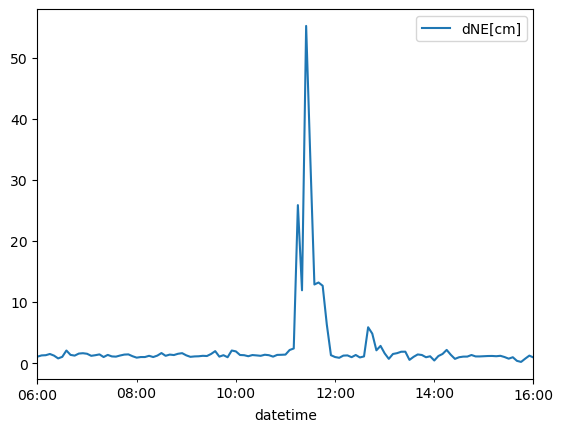

In [841]:
finaldf.loc[finaldf['datetime'].dt.date == hairiot[i]].plot(x='datetime', y='dNE[cm]', kind='line')

i+=1
print(i, '/', len(hairiot), hairiot[i-1])#, finaldf.loc[finaldf['datetime'].dt.date == neghairiot[i-1]]['dNE_med'].mean())